In [1]:
!git clone https://github.com/deepseek-ai/Janus
%cd Janus
!pip install -e .

Cloning into 'Janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 121 (delta 57), reused 41 (delta 41), pack-reused 38 (from 1)
Receiving objects: 100% (121/121), 7.18 MiB | 43.52 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/Janus
Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━

In [2]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:604: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [3]:
# define model location
model_location = "deepseek-ai/Janus-Pro-7B"
multimodal_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_location)
text_processor = multimodal_processor.tokenizer
visual_language_model: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_location, trust_remote_code=True
)
visual_language_model = visual_language_model.to(torch.bfloat16).cuda().eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/89.0k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.85G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/92.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dialogue = [
    {
        "role": "<|User|>",
        "content": f"<image_placeholder>\n What animal is this? Tell me about its habitat and diet. Can you also explain its behavioral characteristics?",
        "images": ['/content/sunflower.jpg'],
    },
    {"role": "<|Assistant|>", "content": ""},
]

# prepare images and format inputs for model
images = load_pil_images(dialogue)
model_inputs = multimodal_processor(
    conversations=dialogue, images=images, force_batchify=True
).to(visual_language_model.device)

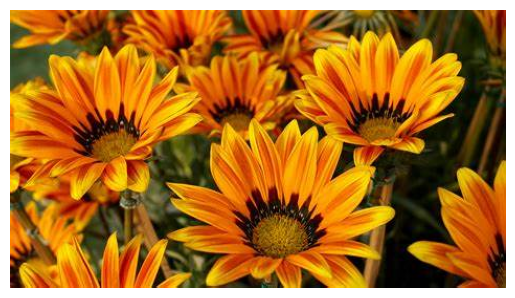

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

# Loading the image
image = Image.open('/content/sunflower.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
# process image through model's vision encoder
embedded_inputs = visual_language_model.prepare_inputs_embeds(**model_inputs)

# generate text response based on image understanding
response = visual_language_model.language_model.generate(
    inputs_embeds=embedded_inputs,
    attention_mask=model_inputs.attention_mask,
    pad_token_id=text_processor.eos_token_id,
    bos_token_id=text_processor.bos_token_id,
    eos_token_id=text_processor.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

result = text_processor.decode(response[0].cpu().tolist(), skip_special_tokens=True)
print(f"{model_inputs['sft_format'][0]}", result)

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
 What animal is this? Tell me about its habitat and diet. Can you also explain its behavioral characteristics?

<|Assistant|>: This image shows a group of flowers, specifically a type of daisy known as the "African Daisy" or "Orange Daisy." These flowers are part of the Asteraceae family and are native to Africa.

**Habitat:**
- African Daisies thrive in warm climates and are commonly found in savannas, grasslands, and open woodlands.
- They prefer well-drained soil and can tolerate a variety of soil types, including sandy and rocky areas.
- These flowers are often seen in areas with full sun exposure, as they require ample sunlight to bloom.

**Diet:**
- African Daisies are herbivorous plants, meaning they primarily feed on sunlight.
- They do not have leaves or stems, s